# Clasificación de Posturas
Basado en el cuaderno Multi-class text classification (TFIDF) de Selene Reyes. Disponible en https://www.kaggle.com/selener/multi-class-text-classification-tfidf

### Importación de bibliotecas y datos

In [1]:
# Importación de bibliotecas a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
# Los tweets para entrenamiento y pruebas se encuentran en el directorio
# StanceTweetLabeled. Listamos el directorio para verificar que se encuentran
# cargados.
import os
print(os.listdir("./StanceTweetLabeled"))

['.~lock.train.csv#', 'test.csv', 'train.csv']


In [3]:
# Importando datos
df_train = pd.read_csv('./StanceTweetLabeled/train.csv' , engine='python')
df_test = pd.read_csv('./StanceTweetLabeled/test.csv' , engine='python')
print("Forma de df_train:",df_train.shape)
print("Forma de df_test:",df_test.shape)

Forma de df_train: (2914, 5)
Forma de df_test: (1956, 5)


El dataset original tiene divididos los datos en datos de prueba y datos de entrenamiento. Vamos a combinarlos en uno sólo debido a que posteriormente dividiremos a los datos aplicando validación cruzada.

In [4]:
df = df_train.append(df_test)
df.shape

(4870, 5)

### Análisis de datos exploratorio

In [5]:
# Impresión de las primeras 2 filas para conocer su estructura
df.head(2)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos


La columna "Target" se refiere al tópico del tweet.
Para conocer cuales son estos podemos obtener sus valores únicos.

In [6]:
df["Target"].unique()

array(['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement',
       'Donald Trump'], dtype=object)

De forma similar para la columna "Stance", que se refiere a la postura que la
 persona toma con respecto a cierto tópico u argumento.

In [7]:
df["Stance"].unique()

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

Las columnas que interesan para el entrenamiento son "Tweet" y "Stance", pues a a partir de cierto tweet, queremos predecir la postura que viene implicita en el mismo. No consideramos la columna "Target" debido a que ninguno de los tópicos del dataset está relacionado con el asunto del Asalto al Capitolio de Estados Unidos 2021.  
Para ello se crea un nuevo dataframe con sólo estas dos columnas.

In [8]:
# Creación de un nuevo dataframe con sólo dos columnas
df1 = df[['Stance', 'Tweet']].copy()

Los tipos de posturas son AGAINST, FAVOR, NONE. Los autores del dataset colocan
a la postura NONE para aquellos tweets que no tienen que ver con los tópicos que ellos eligieron (Hilary Clinton, Legalization of Abortion, etc), así que para este caso de estudio es mejor omitir todos los tweets clasificados con esta postura.  
Primero contamos cuantos tweets hay por cada postura.

In [9]:
df1.groupby('Stance').Tweet.count()

Stance
AGAINST    2409
FAVOR      1205
NONE       1256
Name: Tweet, dtype: int64

Se tienen 1256 tweets clasificados como NONE. Se eliminarán todos estos para quedar con sólo tweets de AGAINST y FAVOR.  
Para ello los ordenamos por postura y nos quedamos con los primeros 3614 registros, debido a que es lo que se obtiene de restarle el número de tweets NONE al total de tweets. (4870 - 1256)

In [10]:
df1 = df1.sort_values(by=['Stance']).head(3614)
df1

,Stance,Tweet
0,AGAINST,"@tedcruz And, #HandOverTheServer she wiped cle..."
2727,AGAINST,RT @AdvocatesOfLife: RT @ProLifeYouth Adopting...
2728,AGAINST,On my bday I'm always so grateful to my bio pa...
2729,AGAINST,That's like being into cannibalism but against...
2731,AGAINST,It should never ever be legal to have an abort...
...,...,...
1226,FAVOR,Excited to hear author @LeoraTanenbaum Slut-S...
1006,FAVOR,"If we do not act, we will be the generation wh..."
1630,FAVOR,@realDonaldTrump Favorites and retweets keep p...
1003,FAVOR,If sea levels get any higher flooding in lowla...


Los diferentes valores de la columna "Stance" se tratarán como clases. Se trata entonces de un problema de dos clases. Se necesita representar a cada clase (postura) como números para que el modelo predictivo pueda entenderlas.

In [11]:
# Creando una nueva columna llamada 'stance_id' con las posturas codificadas
df1['stance_id'] = df1['Stance'].factorize()[0]
stance_id_df = df1[['Stance', 'stance_id']].drop_duplicates()

# Diccionarios para mapear entre el identificador de la postura y la postura
stance_to_id = dict(stance_id_df.values)
id_to_stance = dict(stance_id_df[['stance_id', 'Stance']].values)

print("Impresión de los diccionarios creados")
print("stance_to_id:",stance_to_id)
print("id_to_stance:",id_to_stance)

Impresión de los diccionarios creados
stance_to_id: {'AGAINST': 0, 'FAVOR': 1}
id_to_stance: {0: 'AGAINST', 1: 'FAVOR'}


In [12]:
# Impresión de un subconjunto aleatorio del nuevo dataframe
df1.sample(n=4)

,Stance,Tweet,stance_id
1602,AGAINST,"If Feminism is not hypocritical fake ""equality...",0
915,AGAINST,"@HillaryClinton lies just for the fun of it, i...",0
123,AGAINST,"The devil is our enemy, and our mind is the ba...",0
715,AGAINST,@dougshelton749 @realDonaldTrump #HRC would b...,0


A continuación se muestra un gráfico con el número de de tweets por postura.

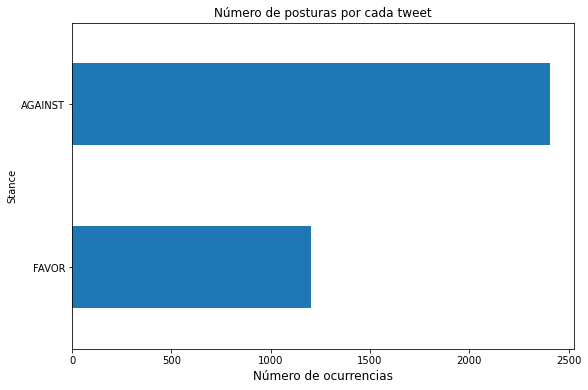

In [13]:
fig = plt.figure(figsize=(9,6),facecolor='white')
df1.groupby('Stance').Tweet.count().sort_values().plot.barh(
  ylim=0, title= 'Número de posturas por cada tweet')
plt.xlabel('Número de ocurrencias', fontsize = 12);

## Preprocesamiento del texto
Para este paso se transformarán los tweets a vectores de  $R^n$ para que el modelo pueda realizar predicciones. Para ello se utilizará TF-IDF.

In [14]:
# Se utiliza un escalamiento logaritmico
# Se remueven palabras que ocurren en menos de 5 documentos
# Se utilizan unigramas y bigramas
# Se remueven stop words en inglés
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# Se transforma cada tweet en un vector de TFIDF
features = tfidf.fit_transform(df1.Tweet).toarray()


# Se utilizan como etiquetas el identificador de la postura
labels = df1.stance_id

features.shape

(3614, 1413)

## Modelos de clasificación
En esta sección se entrenan tres modelos, y mediante validación cruzada de 5 iteraciones se obtendrá la exactitud de cada modelo. Aquel que tenga la mejor exactitud será el elegido como modelo para nuestro caso de estudio.  
Los modelos que se propone usar son:
- Categorical Naive Bayes
- Multinomial Naive Bayes
- Logistic Regression
- Random Forest
- Linear Support Vector Machine
- Non Linear Support Vector Machine


In [15]:
# Los modelos son almacenados en una lista
models = [
  RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
  MultinomialNB(),
  CategoricalNB(),
  LogisticRegression(random_state=0),
  LinearSVC(),
  SVC()
]

# Cross-validation de 5 iteraciones
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
# Se itera sobre la lista de modelos y en la lista entries se almacena
# el nombre del modelo y valores obtenidos de la validación cruzada.
# De la validación cruzada se almacena el identificador de la iteración y
# la exactitud obtenida en cada iteración.
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model,features,labels,scoring='accuracy',cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

# Creamos un nuevo dataframe a partir de la lista entries
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

En este momento se tiene el dataframe cv_df que contiene la lista de exactitudes obtenidas de la validación cruzada de cada modelo. Se tienen 5 valores distintos de exactitud por cada iteración.

In [16]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.680498
1,RandomForestClassifier,1,0.674965
2,RandomForestClassifier,2,0.670816
3,RandomForestClassifier,3,0.666667
4,RandomForestClassifier,4,0.668975
5,MultinomialNB,0,0.749654
6,MultinomialNB,1,0.726141
7,MultinomialNB,2,0.679115
8,MultinomialNB,3,0.656985
9,MultinomialNB,4,0.704986


Para decidir que modelo utilizar, se obtiene el promedio y desviación estándar de las exactitudes de cada modelo.

In [17]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

# Se crea un nuevo dataframe con el promedio y desviación estándar de la
# exactitud de cada modelo.
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean_Accuracy', 'Standard_deviation']
acc

,Mean_Accuracy,Standard_deviation
model_name,,
CategoricalNB,0.666574,0.000206
LinearSVC,0.673494,0.036347
LogisticRegression,0.692310,0.031642
MultinomialNB,0.703376,0.036753
RandomForestClassifier,0.672384,0.005460
SVC,0.688436,0.026901


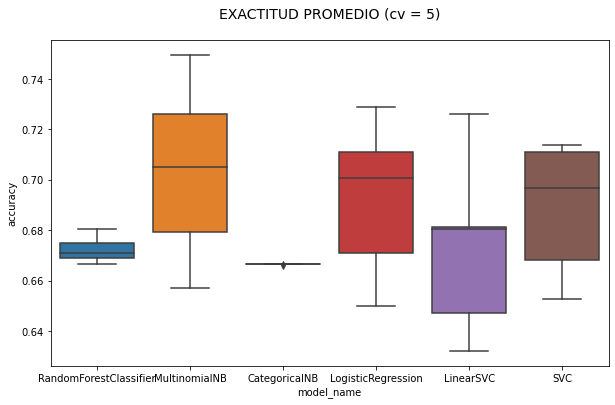

In [18]:
plt.figure(figsize=(10,6),facecolor='white')
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
plt.title("EXACTITUD PROMEDIO (cv = 5)\n", size=14);

Con el diagrama de cajas y vigotes se puede notar que el modelo con mejor exactitud promedio es Multinomial Naive Bayes.
Otro aspecto a destacar es que todos los modelos poseen un rendimiento similar, de entre 0.65 y 0.7, así que el elegir entre uno u otro no varía demasiado.
Para efectos de este trabajo, nos quedaremos con **Multinomial Naive Bayes**.

## Evaluación del modelo elegido


In [19]:
# Se divide los datos en datos de prueba y de entrenamiento
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, 
                                                                labels, 
                                                                df1.index, test_size=0.25, 
                                                                random_state=1)
# Se genera un modelo con los datos de entrenamiento obtenidos
model = MultinomialNB()
model.fit(X_train, y_train)
# Se evalúa con los datos de prueba
y_pred = model.predict(X_test)

### Precisión, exhaustividad y valor F

In [20]:
print('\t\t\tMÉTRICAS DE CLASIFICACIÓN\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df1.Stance.unique()))

			MÉTRICAS DE CLASIFICACIÓN

              precision    recall  f1-score   support

     AGAINST       0.75      0.93      0.83       609
       FAVOR       0.73      0.37      0.49       295

    accuracy                           0.75       904
   macro avg       0.74      0.65      0.66       904
weighted avg       0.74      0.75      0.72       904



### Matríz de confusión
La matriz de confusión es una tabla que representa los valores reales y los valores predecidos. Un buen modelo es aquel que tiene colores oscuros en la diagonal.

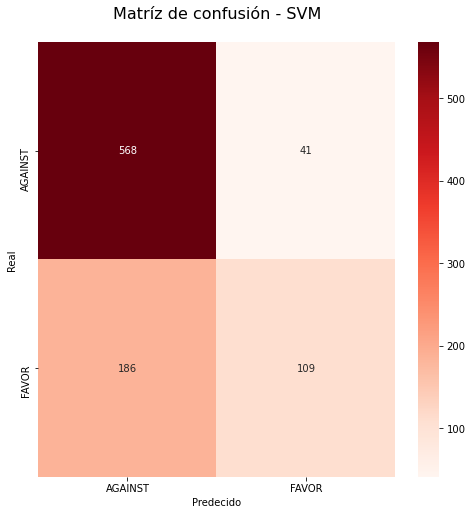

In [21]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8),facecolor='white')
sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d',
            xticklabels=stance_id_df.Stance.values, 
            yticklabels=stance_id_df.Stance.values)
plt.ylabel('Real')
plt.xlabel('Predecido')
plt.title("Matríz de confusión - SVM\n", size=16);

Con los datos observados se puede notar que el clasificador tiende a clasificar las posturas en "AGAINST". Esto probablemente se debe a la alta cantidad de registros que tiene esta clase con respecto a las demás.

In [22]:
df1.groupby('Stance').Tweet.count()

Stance
AGAINST    2409
FAVOR      1205
Name: Tweet, dtype: int64

In [23]:
df1.shape

(3614, 3)

### Corrección del modelo

Para tratar de solucionar esta desviación del modelo, eliminaremos 1204 registros clasificados como AGAINST, esto con el objetivo de que la cantidad de registros por cada clase este balanceada.

In [24]:
# Se ordena el dataframe por la columna Stance, lo que coloca los registros con
# el orden AGAINST, FAVOR, NONE.
# Posteriormente eliminaremos a los primeros 1204 registros, que son parte de
# AGAINST. Esto se hace seleccionando los últimos 2410 registros del dataframe.
# TOTAL_REGISTROS - REGISTROS A ELIMINAR = REGISTROS A MANTENER
# 3614 - 1204 = 2410
df_balanced = df1.sort_values(by=['Stance']).tail(2410)
df_balanced

,Stance,Tweet,stance_id
1516,AGAINST,@deanesmay The Command-and-control mentality r...,0
1525,AGAINST,@Ehsan_Kassim It's time we make the Housewares...,0
31,AGAINST,Jesus response to a religious environment was...,0
29,AGAINST,I still remember the days when I prayed God fo...,0
6,AGAINST,"Morality is not derived from religion, it prec...",0
...,...,...,...
788,FAVOR,"At what point do we rename summer ""The Rainy S...",1
655,FAVOR,Man: this is an issue and needs to be addresse...,1
664,FAVOR,What a great week for social issues #SCOTUS No...,1
900,FAVOR,I stand with @HillaryClinton I know she is for...,1


In [25]:
df_balanced.groupby('Stance').Tweet.count()

Stance
AGAINST    1205
FAVOR      1205
Name: Tweet, dtype: int64

Ahora que las clases están balanceadas, repetimos el proceso de preprocesamiento del texto y entrenamiento del modelo

In [26]:
# Se transforma cada tweet en un vector de TFIDF
# Notar que ahora se utiliza el dataframe df_balanced
features = tfidf.fit_transform(df_balanced.Tweet).toarray()

# Se utilizan como etiquetas el identificador de la postura
labels = df_balanced.stance_id

In [27]:
# Se divide los datos en datos de prueba y de entrenamiento
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features,
                                                                labels,
                                                                df_balanced.index, test_size=0.25,
                                                                random_state=1)
# Se genera un modelo con los datos de entrenamiento obtenidos
model = MultinomialNB()
model.fit(X_train, y_train)
# Se evalúa con los datos de prueba
y_pred = model.predict(X_test)

In [28]:
print('\t\t\tMÉTRICAS DE CLASIFICACIÓN\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df1.Stance.unique()))

			MÉTRICAS DE CLASIFICACIÓN

              precision    recall  f1-score   support

     AGAINST       0.71      0.76      0.73       288
       FAVOR       0.76      0.71      0.74       315

    accuracy                           0.73       603
   macro avg       0.74      0.74      0.73       603
weighted avg       0.74      0.73      0.73       603



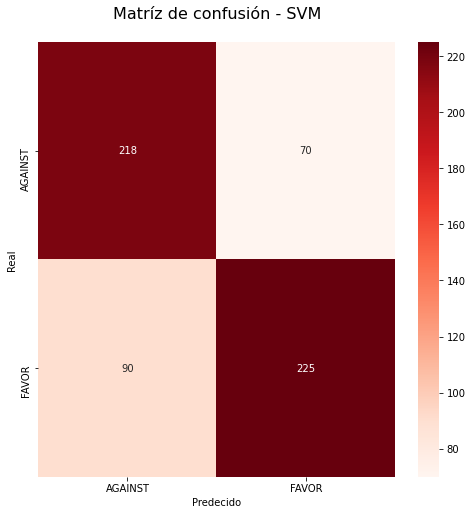

In [29]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8),facecolor='white')
sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d',
            xticklabels=stance_id_df.Stance.values, 
            yticklabels=stance_id_df.Stance.values)
plt.ylabel('Real')
plt.xlabel('Predecido')
plt.title("Matríz de confusión - SVM\n", size=16);

Se nota que esta vez la matriz de confusión ya tiene un patrón con color obscuro en la diagonal.  
Este modelo será el que finalmente utilizaremos.

## Predicción

In [30]:
X = df_balanced['Tweet'] # Datos de entrada
y = df_balanced['Stance'] # Variable a predecir

# TF-IDF aprende el vocabulario e idf de los datos de entrenamiento
# Es decir, se genera un "Vectorizador"
fitted_vectorizer = tfidf.fit(X)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X)

model = MultinomialNB().fit(tfidf_vectorizer_vectors, y)

Para la predicción creamos nuevos tweets que reflejen la postura de una persona. A continuación mostramos dos ejemplos.

In [31]:
new_tweet = """I don't think in that way"""
print(model.predict(fitted_vectorizer.transform([new_tweet])))

['AGAINST']


In [32]:
new_tweet = """She is right"""
print(model.predict(fitted_vectorizer.transform([new_tweet])))

['FAVOR']
